# Projet 8 : Traitez les images pour le système embarqué d’une voiture autonome

* [1. Contexte](#partie1)
* [2. Préparation de l'environnement](#partie2)
    * [2.1 Installation des modules](#partie2.1)
    * [2.2 Librairies](#partie2.2)
    * [2.3 Fonctions](#partie2.3)
* [3. Prétraitement des données](#partie3)
    * [3.1 Compléter le filtrage des groupes](#partie3.1)
    * [3.2 Data augmentation](#partie3.2)
    * [3.3 Data generator](#partie3.3)
    * [3.4 Charger le pipeline d'augmentation et initialiser les générateurs](#partie3.4)
* [4. Recherche de la meilleure data augmentation](#partie4)
    * [4.1 Conception du modèle](#partie4.1)
    * [4.2 Compilation et entrainement](#partie4.2)
* [5. Conclusion](#partie5)

In [ ]:
!nvidia-smi

Mon Jan 13 14:40:24 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   42C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## <font color='red'>1. Contexte</font><a class="anchor" id="partie1"></a>

Ce notebook vise à tester différentes stratégies de data augmentation pour améliorer la robustesse des modèles de segmentation d'images.

L'objectif est d'évaluer leur impact sur les performances en comparant plusieurs niveaux d'augmentation :
- Sans augmentation (référence)
- Augmentation légère (rotations mineures, flips horizontaux, ajustement du contraste)
- Augmentation moyenne (ajout de bruit, flou, rotations modérées)
- Augmentation modérée (déformations élastiques, saturation ajustée)
- Augmentation forte (zooms, distorsions géométriques)
- Augmentation très forte (combinaison de toutes les techniques avancées)

Chaque stratégie est évaluée en fonction des métriques IoU, Dice Coefficient, ainsi que la stabilité de l'entraînement.

## <font color='red'>2. Préparation de l'environnement</font><a class="anchor" id="partie2"></a>

##### <font color='blue'>2.1 Installation des modules</font><a class="anchor" id="partie2.1"></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 637.5/637.5 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.6 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow==2.10 keras==2.10 segmentation-models

ERROR: Could not find a version that satisfies the requirement tensorflow==2.10 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0)
ERROR: No matching distribution found for tensorflow==2.10


In [ ]:
!pip install albumentations

In [ ]:
!pip install pyngrok

In [ ]:
import subprocess
from pyngrok import ngrok

# Démarrer MLFlow en arrière-plan
mlflow_server = subprocess.Popen(["mlflow", "ui", "--port", "5000"])

# Ajouter ton authtoken Ngrok (remplace par ton propre token)
!ngrok config add-authtoken 2o7fRSSTsKkRHY1jl4VoX9qS7AR_5TCYPvixQ8rv7g5PqJp8t

# Créer un tunnel pour accéder à MLFlow UI
public_url = ngrok.connect(5000)
print("MLFlow Tracking UI:", public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
MLFlow Tracking UI: NgrokTunnel: "https://0061-34-124-149-249.ngrok-free.app" -> "http://localhost:5000"


In [ ]:
import mlflow
mlflow.set_experiment("P8 - Image Segmentation - augmentation")

2025/01/22 14:05:07 INFO mlflow.tracking.fluent: Experiment with name 'P8 - Image Segmentation - augmentation' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/444859002672142296', creation_time=1737554707493, experiment_id='444859002672142296', last_update_time=1737554707493, lifecycle_stage='active', name='P8 - Image Segmentation - augmentation', tags={}>

##### <font color='blue'>2.2 Librairies</font><a class="anchor" id="partie2.2"></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import time
import albumentations as A
import mlflow
from PIL import Image
import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Concatenate, GlobalAveragePooling2D, Reshape, Lambda, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import  jaccard_score
from segmentation_models.metrics import IOUScore, FScore
from segmentation_models.losses import DiceLoss
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import MeanIoU
import cv2
from segmentation_models.metrics import IOUScore, FScore
from segmentation_models.losses import DiceLoss
from albumentations.core.composition import OneOf

##### <font color='blue'>2.3 Fonctions</font><a class="anchor" id="partie2.3"></a>

In [ ]:
def load_file_paths(images_path, masks_path, data_cat="train"):
    """
    Charge les chemins des images et des masques pour un type de données spécifique.

    Args:
        images_path (str): Chemin du dossier des images.
        masks_path (str): Chemin du dossier des masques.
        data_cat (str): Type de données ("train", "val", "test").

    Returns:
        list, list: Listes des chemins des images et des masques.
    """
    images_dir = os.path.join(images_path, data_cat)
    masks_dir = os.path.join(masks_path, data_cat)

    # Vérification des répertoires
    if not os.path.exists(images_dir):
        raise FileNotFoundError(f"Le répertoire {images_dir} n'existe pas.")
    if not os.path.exists(masks_dir):
        raise FileNotFoundError(f"Le répertoire {masks_dir} n'existe pas.")

    cities = os.listdir(images_dir)
    image_files, mask_files = [], []

    for city in cities:
        city_img_dir = os.path.join(images_dir, city)
        city_mask_dir = os.path.join(masks_dir, city)

        # Vérifier si le sous-dossier existe dans "masks_path"
        if not os.path.exists(city_mask_dir):
            print(f"Attention : Le dossier des masques pour la ville '{city}' est manquant.")
            continue

        # Charger les fichiers
        city_images = [os.path.join(city_img_dir, f) for f in os.listdir(city_img_dir) if f.endswith("_leftImg8bit.png")]
        city_masks = [os.path.join(city_mask_dir, f) for f in os.listdir(city_mask_dir) if f.endswith("_gtFine_labelIds.png")]

        if len(city_images) != len(city_masks):
            print(f"Attention : Incohérence dans le nombre de fichiers pour la ville '{city}'.")

        image_files.extend(sorted(city_images))
        mask_files.extend(sorted(city_masks))

    return image_files, mask_files

In [ ]:
def show_image_and_mask(image_path, mask_path, save_path=None):
    """
    Affiche une image et son masque côte à côte.
    Si un chemin est fourni, enregistre la figure au format PNG.

    Args:
        image_path (str): Chemin de l'image RGB.
        mask_path (str): Chemin du masque associé.
        save_path (str, optional): Chemin pour sauvegarder l'image.
    """
    img = Image.open(image_path)
    mask = Image.open(mask_path)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(img)
    ax[0].set_title("Image RGB")
    ax[0].axis("off")

    ax[1].imshow(mask)
    ax[1].set_title("Masque (color)")
    ax[1].axis("off")

    # Enregistrer l’image si un chemin est fourni
    if save_path:
        fig.savefig(save_path, bbox_inches="tight")

    plt.show()

In [ ]:
def filter_groups_in_mask(mask_path, class_to_group):
    mask = np.array(Image.open(mask_path))
    group_mask = np.zeros_like(mask)
    for cls, grp in class_to_group.items():
        group_mask[mask == cls] = grp
    return group_mask

def apply_cityscapes_palette(group_mask):
    cityscapes_palette = [
        (128, 64, 128),  # road (flat)
        (244, 35, 232),  # sidewalk (flat)
        (70, 70, 70),    # building (construction)
        (102, 102, 156), # wall (construction)
        (190, 153, 153), # fence (construction)
        (153, 153, 153), # pole (object)
        (250, 170, 30),  # traffic light (object)
        (220, 220, 0),   # traffic sign (object)
        (107, 142, 35),  # vegetation (nature)
        (152, 251, 152), # terrain (nature)
        (70, 130, 180),  # sky (sky)
        (220, 20, 60),   # person (human)
        (255, 0, 0),     # rider (human)
        (0, 0, 142),     # car (vehicle)
        (0, 0, 70),      # truck (vehicle)
        (0, 60, 100),    # bus (vehicle)
        (0, 80, 100),    # on rails (vehicle)
        (0, 0, 230),     # motorcycle (vehicle)
        (119, 11, 32),   # bicycle (vehicle)
        (0, 0, 0)        # void
    ] + [(0, 0, 0)] * (256 - 20)

    pil_mask = Image.fromarray(group_mask.astype('uint8'))
    flat_palette = [value for color in cityscapes_palette for value in color]
    pil_mask.putpalette(flat_palette)
    return pil_mask

In [ ]:
import mlflow
import os

# **Démarrer un run MLFlow**
with mlflow.start_run(run_name="EDA_Analyse_Structure"):

    # Définir les chemins vers les images et les masques
    images_path = "/content/drive/My Drive/projet 8/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit"
    masks_path = "/content/drive/My Drive/projet 8/P8_Cityscapes_gtFine_trainvaltest/gtFine"

    # Vérification des dossiers
    images_dirs = os.listdir(images_path)
    masks_dirs = os.listdir(masks_path)

    print("Contenu des dossiers :")
    print("Images :", images_dirs)
    print("Masques :", masks_dirs)

    # **Enregistrement des informations dans MLFlow**
    mlflow.log_param("Nombre de dossiers images", len(images_dirs))
    mlflow.log_param("Nombre de dossiers masques", len(masks_dirs))

    # **Chargement des chemins des fichiers (sans les intégrer à MLFlow maintenant)**
    train_images, train_masks = load_file_paths(images_path, masks_path, "train")
    val_images, val_masks = load_file_paths(images_path, masks_path, "val")
    test_images, test_masks = load_file_paths(images_path, masks_path, "test")

    # **Enregistrement des métriques dans MLFlow**
    mlflow.log_metric("nb_images_train", len(train_images))
    mlflow.log_metric("nb_masks_train", len(train_masks))
    mlflow.log_metric("nb_images_val", len(val_images))
    mlflow.log_metric("nb_masks_val", len(val_masks))
    mlflow.log_metric("nb_images_test", len(test_images))
    mlflow.log_metric("nb_masks_test", len(test_masks))

    print("Analyse de la structure des fichiers terminée et enregistrée dans MLFlow.")


Contenu des dossiers :
Images : ['train', 'val', 'test']
Masques : ['test', 'val', 'train']
Analyse de la structure des fichiers terminée et enregistrée dans MLFlow.


In [ ]:
def total_loss(y_true, y_pred):
    """
    Combine binary_crossentropy et dice_loss pour améliorer les performances globales.

    Args:
        y_true (Tensor): Masques réels.
        y_pred (Tensor): Masques prédits.

    Returns:
        Tensor: Valeur de la perte combinée.
    """
    loss = binary_crossentropy(y_true, y_pred) + (3 * dice_loss(y_true, y_pred))
    return loss

In [ ]:
def dice_coeff(y_true, y_pred):
    """
    Calcule le coefficient de Dice, une mesure de similarité pour la segmentation.

    Args:
        y_true (Tensor): Masques vrais (ground truth).
        y_pred (Tensor): Masques prédits.

    Returns:
        float: Coefficient de Dice.
    """
    smooth = 1.0
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

## <font color='red'>3. Prétraitement des données</font><a class="anchor" id="partie3"></a>

##### <font color='blue'>3.1 Compléter le Filtrage des Groupes</font><a class="anchor" id="partie3.1"></a>

In [ ]:
with mlflow.start_run(run_name="EDA_Filtrage_Groupes"):
    # Définition des classes et groupes
    class_to_group = {
        -1: 0, 0: 0, 1: 0, 2: 0,  # void
        7: 1, 8: 1, 9: 1, 10: 1,  # flat
        11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2,  # construction
        17: 3, 18: 3, 19: 3, 20: 3,  # object
        21: 4, 22: 4,  # nature
        23: 5,  # sky
        24: 6, 25: 6,  # human
        26: 7, 27: 7, 28: 7, 29: 7, 30: 7, 31: 7, 32: 7, 33: 7  # vehicle
    }

    example_mask_path = "/content/drive/My Drive/projet 8/P8_Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png"

    # Application du filtrage des groupes
    filtered_group_mask = filter_groups_in_mask(example_mask_path, class_to_group)
    colored_mask = apply_cityscapes_palette(filtered_group_mask)

    # Loguer le nombre de pixels par groupe
    unique, counts = np.unique(filtered_group_mask, return_counts=True)
    group_distribution = dict(zip(unique, counts))

    for group, count in group_distribution.items():
        mlflow.log_metric(f"group_{group}_pixels", count)

    # Sauvegarder l'image filtrée et colorisée dans MLFlow
    mask_output_path = "filtered_mask.png"
    colored_mask.save(mask_output_path)
    mlflow.log_artifact(mask_output_path)

    print("Filtrage des groupes et enregistrement des résultats terminés dans MLFlow.")

Filtrage des groupes et enregistrement des résultats terminés dans MLFlow.


##### <font color='blue'>3.2 Data augmentation</font><a class="anchor" id="partie3.2"></a>

In [ ]:
def get_augmentation_pipeline(level="moyen"):
    """
    Crée une pipeline d'augmentations dynamiques pour les images et les masques selon le niveau choisi.

    Args:
        level (str): Niveau d'augmentation. Options: "léger", "moyen", "fort", "modérée", "très fort".

    Returns:
        albumentations.Compose: Pipeline d'augmentations.
    """
    if level == "léger":
        augmentation = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Resize(height=256, width=256)
        ])

    elif level == "moyen":
        augmentation = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.GaussNoise(p=0.1),
            A.Blur(blur_limit=(3, 7), p=0.1),
            A.Rotate(limit=15, p=0.3),
            A.Resize(height=256, width=256)
        ])

    elif level == "fort":
        augmentation = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.4),
            A.GaussNoise(p=0.2),
            A.Blur(blur_limit=(3, 7), p=0.2),
            A.Rotate(limit=30, p=0.4),
            A.RandomScale(scale_limit=0.2, p=0.3),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
            A.GridDistortion(p=0.2),
            A.Resize(height=256, width=256)
        ])

    elif level == "modérée":
        augmentation = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
            A.Blur(blur_limit=3, p=0.3),
            A.Resize(height=256, width=256)
        ])

    elif level == "très fort":
        augmentation = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.GaussNoise(p=0.3),
            A.Blur(blur_limit=(3, 7), p=0.3),
            A.Rotate(limit=45, p=0.5),
            A.RandomScale(scale_limit=0.3, p=0.4),
            A.ElasticTransform(alpha=2, sigma=100, p=0.4),
            A.GridDistortion(p=0.3),
            A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5),
            A.Resize(height=256, width=256)
        ])

    else:
        raise ValueError("Le niveau d'augmentation doit être 'léger', 'moyen', 'fort', 'modérée' ou 'très fort'.")

    return augmentation

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


##### <font color='blue'>3.3 Data generator</font><a class="anchor" id="partie3.3"></a>

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    """
    Générateur de données avec augmentation dynamique pour l'entraînement et la validation.
    """

    def __init__(self, image_paths, mask_paths, batch_size, img_size=(256, 256), augmentation=None, shuffle=True, class_to_group=None, num_classes=8):
        """
        Initialisation du générateur de données.
        """
        assert len(image_paths) == len(mask_paths), "Les listes d'images et de masques doivent avoir la même longueur."
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.img_size = img_size
        self.augmentation = augmentation
        self.shuffle = shuffle
        self.class_to_group = class_to_group
        self.num_classes = num_classes
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()

        # Loguer les paramètres du DataGenerator dans MLFlow
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("image_size", img_size)
        mlflow.log_param("num_classes", num_classes)
        mlflow.log_param("shuffle", shuffle)

    def __len__(self):
        """Nombre de lots par époque."""
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        """Génère un lot de données."""
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        image_paths_temp = [self.image_paths[k] for k in indexes]
        mask_paths_temp = [self.mask_paths[k] for k in indexes]
        X, y = self.__data_generation(image_paths_temp, mask_paths_temp)
        return X, y

    def on_epoch_end(self):
        """Mélange les données après chaque époque."""
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, image_paths_temp, mask_paths_temp):
        """Prépare les lots."""
        X = np.empty((self.batch_size, *self.img_size, 3), dtype=np.float32)
        y = np.empty((self.batch_size, *self.img_size, self.num_classes), dtype=np.float32)

        i = 0
        while i < self.batch_size:
            idx = np.random.randint(len(image_paths_temp))
            image_path = image_paths_temp[idx]
            mask_path = mask_paths_temp[idx]

            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.img_size[1], self.img_size[0]))

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (self.img_size[1], self.img_size[0]), interpolation=cv2.INTER_NEAREST)  # ✅ Correction

            unique_classes = np.unique(mask)
            if len(unique_classes) < 3:
                continue

            if self.augmentation:
                augmented = self.augmentation(image=image, mask=mask)
                image, mask = augmented['image'], augmented['mask']

            X[i] = image / 255.0
            y[i] = self._remap_and_one_hot_encode(mask)
            i += 1

        return X, y

    def _remap_and_one_hot_encode(self, mask):
        """Remappe les classes de masque et effectue un encodage one-hot."""
        remapped_mask = np.zeros_like(mask, dtype=np.int32)

        if self.class_to_group:
            for cls, grp in self.class_to_group.items():
                remapped_mask[mask == cls] = grp
        else:
            remapped_mask = mask

        one_hot_mask = tf.keras.utils.to_categorical(remapped_mask, num_classes=self.num_classes)
        return one_hot_mask.astype('float32')

    def compute_class_weights(self):
        """Calcule les poids pour chaque classe et les logue dans MLFlow."""
        pixel_counts = np.zeros(self.num_classes, dtype=np.int64)

        for mask_path in self.mask_paths:
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, self.img_size[::-1], interpolation=cv2.INTER_NEAREST)

            for cls, grp in self.class_to_group.items():
                pixel_counts[grp] += np.sum(mask == cls)

        total_pixels = np.sum(pixel_counts)
        class_weights = total_pixels / (self.num_classes * pixel_counts)
        normalized_weights = class_weights / np.sum(class_weights)

        # Loguer les poids des classes dans MLFlow
        for i, weight in enumerate(normalized_weights):
            mlflow.log_param(f"class_weight_{i}", float(weight))

        return normalized_weights

## <font color='red'>4. Recherche de la meilleure data augmentation</font><a class="anchor" id="partie4"></a>

##### <font color='blue'>4.1 conception du modele Unet Mini</font><a class="anchor" id="partie4.1"></a>

In [ ]:
def unet_mini(input_size=(256, 256, 3), n_classes=32):
    """
    Implémente un modèle U-Net simplifié avec des convolutions dilatées.

    Args:
        input_size (tuple): Dimensions des images d'entrée (par défaut 256x256x3).
        n_classes (int): Nombre de classes pour la segmentation (par défaut 8).

    Returns:
        Model: Modèle U-Net Mini.
    """
    inputs = Input(input_size)

    # Encodeur
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Goulot d'étranglement avec convolution dilatée
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same', dilation_rate=2)(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same', dilation_rate=4)(c3)
    c3 = BatchNormalization()(c3)

    # Décodeur
    u1 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c3)
    u1 = concatenate([u1, c2])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)

    u2 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c4)
    u2 = concatenate([u2, c1])
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    # Couche de sortie
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c5)

    return Model(inputs, outputs)

with mlflow.start_run(run_name="Unet Mini - Conception") as run:
    start_time = time.time()  # Début chrono

    # Instancier le modèle
    unet_model = unet_mini(input_size=(256, 256, 3), n_classes=8)

    # Afficher le résumé du modèle
    model_summary = []
    unet_model.summary(print_fn=lambda x: model_summary.append(x))
    model_summary = "\n".join(model_summary)

    # Enregistrer le résumé du modèle dans MLFlow
    mlflow.log_text(model_summary, "unet_mini_summary.txt")

    # Temps de conception du modèle
    elapsed_time = time.time() - start_time
    mlflow.log_metric("conception_time", elapsed_time)

print(f"Modèle U-Net Mini conçu et loggé dans MLFlow en {elapsed_time:.2f} secondes.")

Modèle U-Net Mini conçu et loggé dans MLFlow en 0.24 secondes.


##### <font color='blue'>4.2 Charger le pipeline d'augmentation et initialiser les générateurs</font><a class="anchor" id="partie4.2"></a>

In [ ]:
# Liste des niveaux d'augmentation à tester
augmentation_levels = ["sans", "léger", "moyen", "fort", "modérée", "très fort"]

# Déclaration des métriques et de la fonction de perte
dice_loss = DiceLoss()
iou_score = IOUScore(threshold=0.5)
f_score = FScore(threshold=0.5)

# Stockage des résultats
results = []

for level in augmentation_levels:
    print(f"Entraînement avec l'augmentation: {level}...")

    with mlflow.start_run(run_name=f"Data Augmentation - {level}") as run:
        start_time = time.time()

        # Générer le pipeline d'augmentation correspondante
        augmentation_pipeline = None if level == "sans" else get_augmentation_pipeline(level=level)

        # Initialisation des DataGenerators avec l'augmentation sélectionnée
        train_gen = DataGenerator(
            train_images,
            train_masks,
            batch_size=16,
            img_size=(256, 256),
            augmentation=augmentation_pipeline,
            class_to_group=class_to_group,
            num_classes=8
        )

        val_gen = DataGenerator(
            val_images,
            val_masks,
            batch_size=16,
            img_size=(256, 256),
            augmentation=None,  # Pas d'augmentation sur le set de validation
            class_to_group=class_to_group,
            num_classes=8
        )

        # Loguer le niveau d'augmentation dans MLFlow
        mlflow.log_param("augmentation_level", level)

        # Compilation du modèle
        unet_model = unet_mini(input_size=(256, 256, 3), n_classes=8)
        unet_model.compile(
            optimizer=Adam(learning_rate=1e-4),
            loss=total_loss,  # Utilisation de Total Loss
            metrics=[iou_score, f_score, dice_coeff]
        )

        # Entraînement du modèle
        history = unet_model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=10,  # On reste sur 10 epochs pour comparaison rapide
            callbacks=[EarlyStopping(monitor="val_loss", patience=3, mode="min")]
        )

        # Récupérer les résultats finaux
        final_loss = history.history["val_loss"][-1]
        final_iou = history.history["val_iou_score"][-1]
        final_f1 = history.history["val_f1-score"][-1]
        final_dice = history.history["val_dice_coeff"][-1]
        training_time = time.time() - start_time

        # Stocker les résultats
        results.append([level, final_loss, final_iou, final_f1, final_dice, training_time])

        print(f"Entraînement avec {level} terminé en {training_time:.2f} secondes.")

# Création du DataFrame récapitulatif
import pandas as pd
df_results = pd.DataFrame(results, columns=["Augmentation Level", "Validation Loss", "IoU Score", "F1-Score", "Dice Coefficient", "Training Time (s)"])

# Définir le chemin où sauvegarder le fichier CSV sur Google Drive
csv_path = "/content/drive/My Drive/projet 8/results_6_data_augmentation.csv"

# Sauvegarde des résultats sous forme de CSV
df_results.to_csv(csv_path, index=False)

# Affichage des résultats
from IPython.display import display
display(df_results)

Entraînement avec l'augmentation: sans...
Epoch 1/10
185/185 [==============================] - 471s 3s/step - loss: 2.4111 - iou_score: 0.3538 - f1-score: 0.4506 - dice_coeff: 0.5513 - val_loss: 3.4817 - val_iou_score: 0.0490 - val_f1-score: 0.0703 - val_dice_coeff: 0.3626
Epoch 2/10
185/185 [==============================] - 467s 3s/step - loss: 1.8102 - iou_score: 0.5030 - f1-score: 0.5991 - dice_coeff: 0.7627 - val_loss: 3.3567 - val_iou_score: 0.0942 - val_f1-score: 0.1412 - val_dice_coeff: 0.4152
Epoch 3/10
185/185 [==============================] - 467s 3s/step - loss: 1.6343 - iou_score: 0.5414 - f1-score: 0.6442 - dice_coeff: 0.7999 - val_loss: 2.0514 - val_iou_score: 0.4123 - val_f1-score: 0.5337 - val_dice_coeff: 0.6879
Epoch 4/10
185/185 [==============================] - 467s 3s/step - loss: 1.5071 - iou_score: 0.5697 - f1-score: 0.6778 - dice_coeff: 0.8177 - val_loss: 1.6310 - val_iou_score: 0.5166 - val_f1-score: 0.6378 - val_dice_coeff: 0.7731
Epoch 5/10
185/185 [======

<ipython-input-29-763b327a11bd>:39: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),


Epoch 1/10
185/185 [==============================] - 481s 3s/step - loss: 2.5309 - iou_score: 0.3047 - f1-score: 0.4078 - dice_coeff: 0.5221 - val_loss: 3.6105 - val_iou_score: 0.0530 - val_f1-score: 0.0787 - val_dice_coeff: 0.3720
Epoch 2/10
185/185 [==============================] - 478s 3s/step - loss: 1.9794 - iou_score: 0.4393 - f1-score: 0.5558 - dice_coeff: 0.7028 - val_loss: 3.4029 - val_iou_score: 0.0963 - val_f1-score: 0.1452 - val_dice_coeff: 0.4236
Epoch 3/10
185/185 [==============================] - 478s 3s/step - loss: 1.8484 - iou_score: 0.4649 - f1-score: 0.5839 - dice_coeff: 0.7320 - val_loss: 2.1044 - val_iou_score: 0.3761 - val_f1-score: 0.4939 - val_dice_coeff: 0.7181
Epoch 4/10
185/185 [==============================] - 477s 3s/step - loss: 1.7585 - iou_score: 0.4830 - f1-score: 0.6050 - dice_coeff: 0.7490 - val_loss: 1.6448 - val_iou_score: 0.5201 - val_f1-score: 0.6373 - val_dice_coeff: 0.7778
Epoch 5/10
185/185 [==============================] - 478s 3s/step -

,Augmentation Level,Validation Loss,IoU Score,F1-Score,Dice Coefficient,Training Time (s)
0,sans,1.202294,0.593455,0.713597,0.840556,4674.127475
1,léger,1.188901,0.601575,0.720817,0.837261,4687.173068
2,moyen,1.193900,0.598940,0.712954,0.841340,4708.765272
3,fort,1.280387,0.569966,0.687934,0.821273,4792.935228
4,modérée,1.260652,0.572788,0.695323,0.827710,4767.465860
5,très fort,1.369935,0.542283,0.660405,0.804376,4849.268191


##### <font color='blue'>4.3 Visualisation de quelques exemples</font><a class="anchor" id="partie4.3"></a>

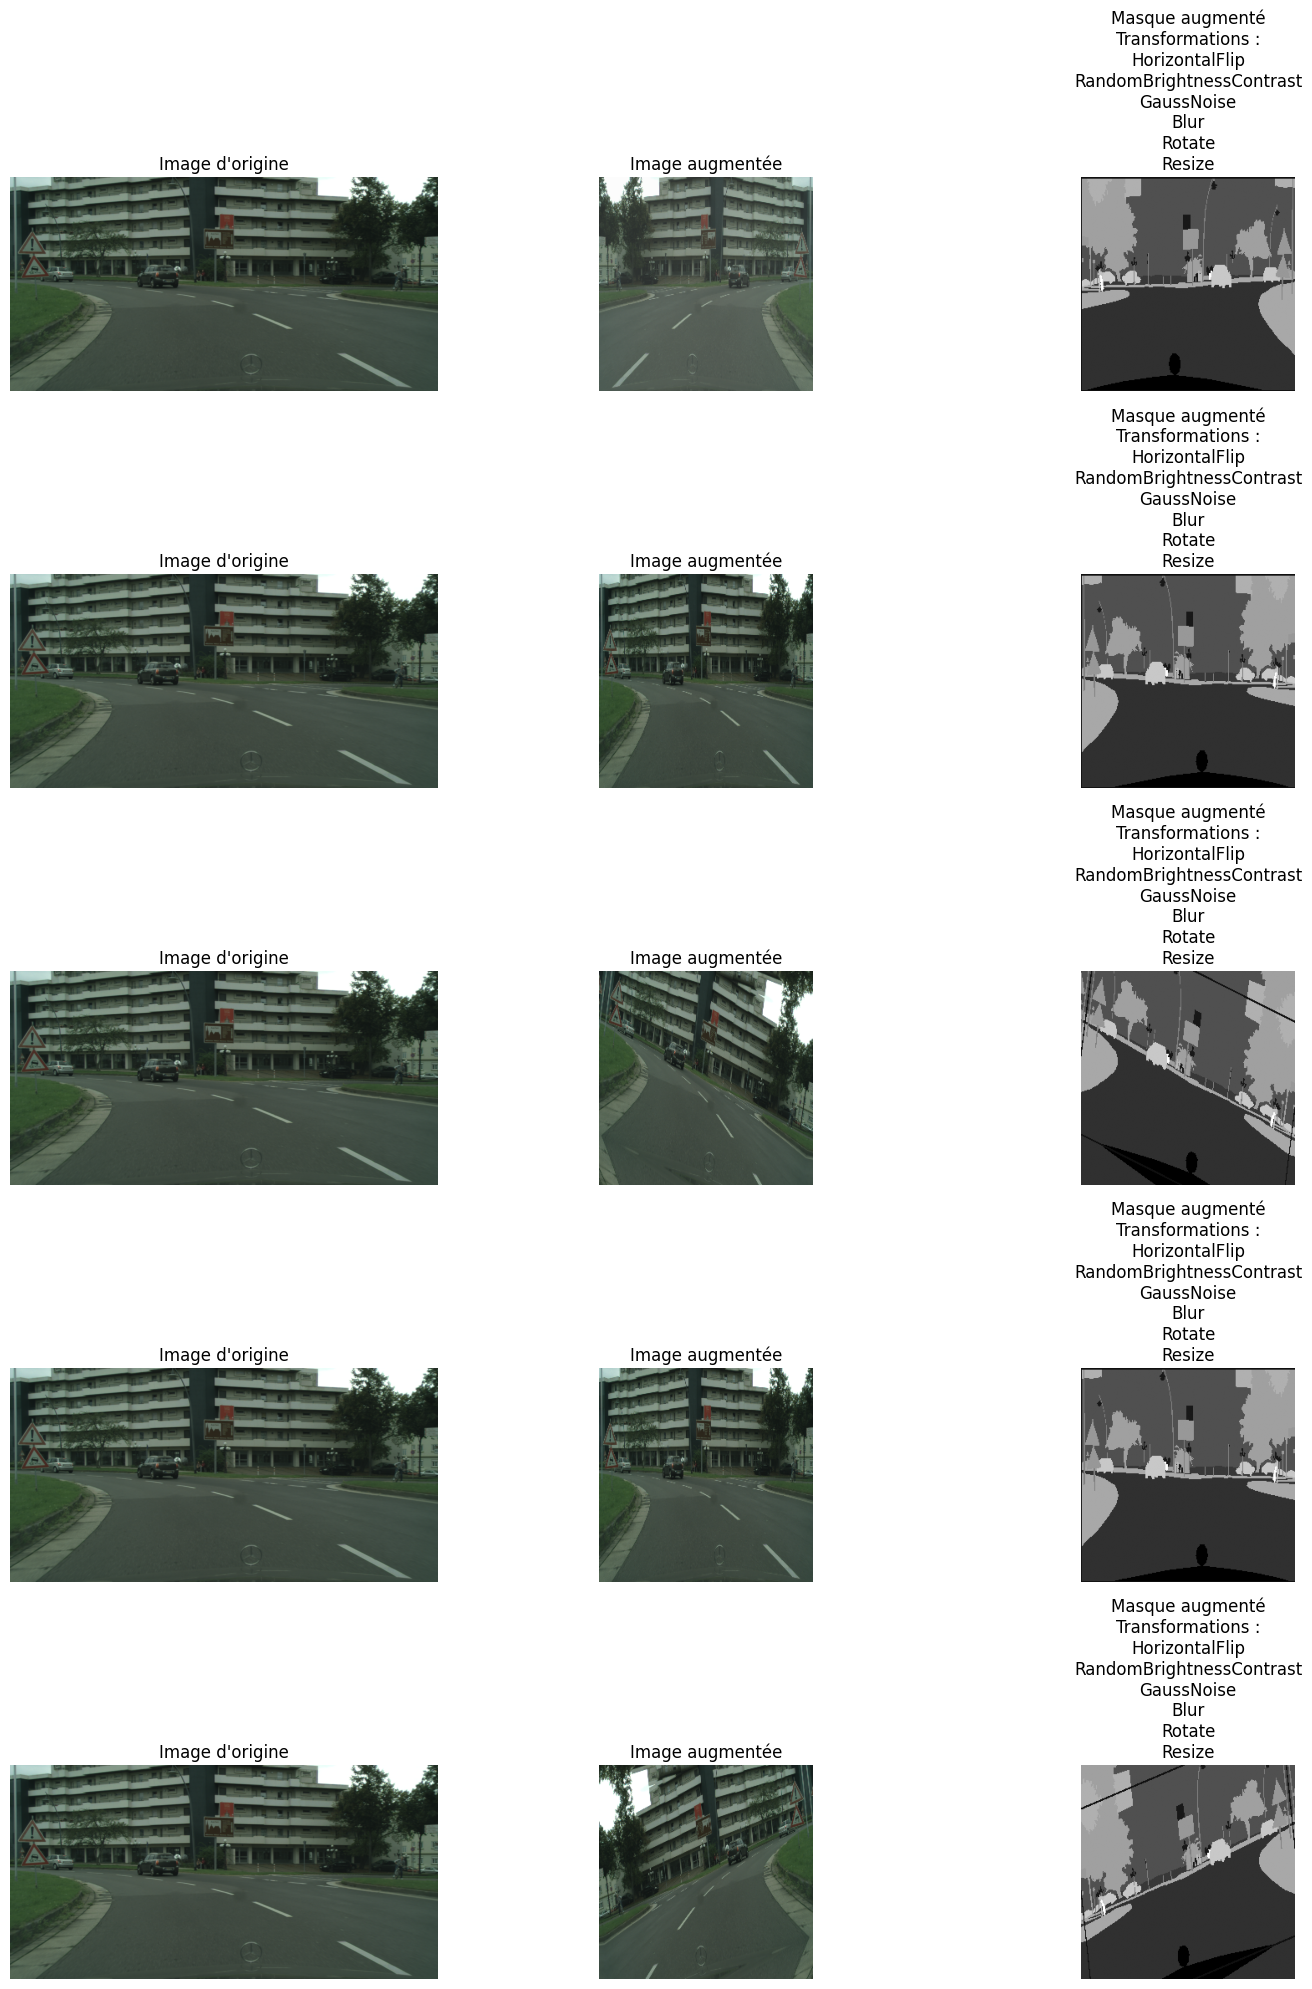

In [ ]:
# Charger le pipeline d'augmentation
augmentation_pipeline = get_augmentation_pipeline(level="moyen")

# Fonction pour charger une image et son masque
def load_image_and_mask(image_path, mask_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return image, mask

# Exemple de chemins d'images et de masques
example_image_path = os.path.join(images_path, "train/aachen/aachen_000000_000019_leftImg8bit.png")
example_mask_path = os.path.join(masks_path, "train/aachen/aachen_000000_000019_gtFine_labelIds.png")

# Charger une image et son masque
image, mask = load_image_and_mask(example_image_path, example_mask_path)

# Fonction pour obtenir une description des transformations appliquées
def describe_augmentation(pipeline, image, mask):
    augmented = pipeline(image=image, mask=mask)
    transformations = []
    for transform in pipeline.transforms:
        if hasattr(transform, "p") and transform.p > 0:  # Si la transformation est conditionnelle
            if hasattr(transform, "apply"):
                transformations.append(transform.__class__.__name__)
    return augmented["image"], augmented["mask"], transformations

# Appliquer l'augmentation plusieurs fois pour voir des variations
augmented_images = []
augmented_masks = []
transform_descriptions = []
for _ in range(5):  # Générer 5 exemples
    augmented_image, augmented_mask, transformations = describe_augmentation(
        augmentation_pipeline, image, mask
    )
    augmented_images.append(augmented_image)
    augmented_masks.append(augmented_mask)
    transform_descriptions.append(transformations)

# Visualiser les résultats
fig, axes = plt.subplots(5, 3, figsize=(15, 20))
for i in range(5):
    axes[i, 0].imshow(image)
    axes[i, 0].set_title("Image d'origine")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(augmented_images[i])
    axes[i, 1].set_title("Image augmentée")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(augmented_masks[i], cmap="gray")
    axes[i, 2].set_title("Masque augmenté\nTransformations :\n" + "\n".join(transform_descriptions[i]))
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()


## <font color='red'>5. Conclusion</font><a class="anchor" id="partie5"></a>

Après avoir testé 6 niveaux de data augmentation, l’augmentation légère
s'est révélée être la meilleure stratégie.

Points clés :
- Meilleur IoU Score (0.602) et F1-Score (0.721), indiquant une segmentation plus précise.
- Dice Coefficient stable (0.837), proche des meilleures valeurs obtenues.
- Temps d’entraînement similaire aux autres stratégies (~4687s), sans complexité supplémentaire.

Les stratégies d'augmentation plus fortes n'ont pas amélioré les résultats.
Au contraire, l'augmentation très forte a **dégradé les performances** (IoU = 0.542),
probablement en raison d’une transformation excessive des images,
rendant l’apprentissage plus difficile.

Ces résultats justifient l’utilisation de l’augmentation légère comme
le meilleur compromis entre **performance, stabilité et rapidité d'entraînement**.